In [75]:
import torch
import torchvision

In [76]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [77]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Loading the data

In [78]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/mnist', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('data/mnist', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [79]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

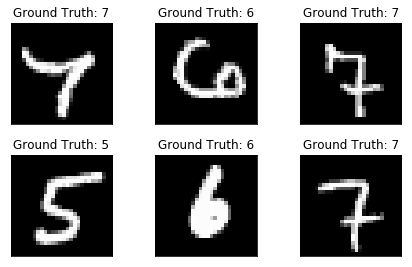

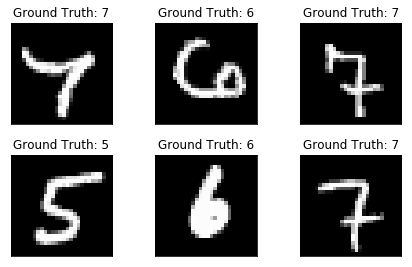

In [80]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Building the network

In [81]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [89]:
class NetSeparated(nn.Module):
    def __init__(self, subgroup_size):
        super(NetSeparated, self).__init__()
        self.subgroup_size = subgroup_size
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, self.subgroup_size*10)
        #self.fc2 = nn.Linear(50, 10)
        self.fc2=list()
        for i in range(10):
          self.fc2.append(nn.Linear(self.subgroup_size, 1))
          self.fc2[-1].to(device)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.last_layer = F.relu(self.fc1(x))
        #x = F.dropout(self.last_layer, training=self.training)
        
        x_list = []
        for i in range(10):
          x_list.append(self.fc2[i](x[:, i*self.subgroup_size:(i+1)*self.subgroup_size]))
        x = torch.cat(x_list, 1)
        return F.log_softmax(x)

In [100]:

class Net(nn.Module):
    def __init__(self, subgroups, sg_size=1):
        self.subgroups = []
        for s in subgroups:
            self.subgroups.append([x*sg_size+i for x in s for i in range(sg_size)])
        subgroup_sizes = [len(x) for x in self.subgroups]
        neurons_n = sum(subgroup_sizes)
        print(max(subgroup_sizes), neurons_n)
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, neurons_n)
        #self.fc2 = nn.Linear(50, 10)
        self.fc2=list()
        for sg in subgroup_sizes:
          self.fc2.append(nn.Linear(sg, 1))
          self.fc2[-1].to(device)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        self.last_layer = F.relu(self.fc1(x))
        #x = F.dropout(self.last_layer, training=self.training)
        
        x_list = []
        for i in range(10):
          x_list.append(
              self.fc2[i](x[:, self.subgroups[i]])
              )

        x = torch.cat(x_list, 1)
        return F.log_softmax(x)

# Training

In [122]:
def train(epoch, network, train_losses, train_counter, optimizer):
  network = network.to(device)
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    data = data.to(device)
    output = network(data)
    loss = F.nll_loss(output, target.to(device))
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      #  epoch, batch_idx * len(data), len(train_loader.dataset),
      #  100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [123]:
def test(network, test_losses, test_counter):
  network = network.to(device)
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      output = network(data).cpu()
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1].cpu()
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [131]:
def run_on_subgroups(subgroups):
  network = Net(subgroups, sg_size=2)
  optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                        momentum=momentum)

  train_losses = []
  train_counter = []
  test_losses = []
  test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

  test(network, test_losses, test_counter)
  for epoch in range(1, n_epochs + 1):
    train(epoch, network, train_losses, train_counter, optimizer)
    acc = test(network, test_losses, test_counter)

  return acc

In [132]:
# subgroups = [[0, 5],
#              [1, 6],
#              [4, 7],
#              [3, 4, 8],
#              [9],
#              [3, 10],
#              [2, 11],
#              [1, 12],
#              [0, 2, 13],
#              [0, 14]
#              ]
subgroups = [[4, 6, 28, 43, 45],
 [8, 38],
 [0, 20, 23, 30, 33, 35, 39],
 [9, 15, 31, 47, 49],
 [16, 21, 23, 26, 27, 45, 47, 48],
 [1, 14, 23, 25, 26, 35, 37, 39, 44],
 [4, 6, 11, 14, 23, 25, 29, 41, 49],
 [0, 11, 14, 17, 19, 22, 30, 33, 38, 41, 46, 49],
 [2, 3],
 [4, 12, 16, 24, 28, 34, 40]]

run_on_subgroups(subgroups)

24 132


/home/c01ekar/anaconda3/envs/diseNN/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/c01ekar/anaconda3/envs/diseNN/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3321, Accuracy: 810/10000 (8%)


Test set: Avg. loss: 1.5291, Accuracy: 5878/10000 (58%)


Test set: Avg. loss: 1.2458, Accuracy: 6692/10000 (66%)


Test set: Avg. loss: 1.0788, Accuracy: 7064/10000 (70%)


Test set: Avg. loss: 0.9595, Accuracy: 7420/10000 (74%)


Test set: Avg. loss: 0.9144, Accuracy: 7535/10000 (75%)



tensor(75)

In [127]:
network = NetSeparated(6)
             
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

test(network, test_losses, test_counter)
for epoch in range(1, n_epochs + 1):
  train(epoch, network, train_losses, train_counter, optimizer)
  acc = test(network, test_losses, test_counter)

/home/c01ekar/anaconda3/envs/diseNN/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/c01ekar/anaconda3/envs/diseNN/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3827, Accuracy: 892/10000 (8%)


Test set: Avg. loss: 1.8535, Accuracy: 4430/10000 (44%)


Test set: Avg. loss: 1.6584, Accuracy: 5194/10000 (51%)


Test set: Avg. loss: 1.5023, Accuracy: 5948/10000 (59%)


Test set: Avg. loss: 1.2997, Accuracy: 6704/10000 (67%)


Test set: Avg. loss: 1.2763, Accuracy: 7109/10000 (71%)

